## Описание проекта

Вы — специалист по Data Science в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту. Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы

* Загрузка данных
* Анализ данных
* Предобработка данных
* Построение модели
* Подбор гиперпараметров и выбор лучшей модели
* Анализ важности признаков
* Вывод

Описание таблиц:

* collisions — общая информация о ДТП.
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

* parties — информация об участниках ДТП.
Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

* vehicles — информация о пострадавших машинах.
Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Импорт необходимых библиотек

In [ ]:
!pip install -q psycopg2
!pip install -q optuna

In [ ]:
from sqlalchemy import create_engine
import os
import optuna
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, precision_recall_curve, auc
import torch
import torch.nn as nn
from math import ceil
import warnings
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from operator import itemgetter
import psycopg2
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

## Подключение к БД и загрузка таблицы sql

In [ ]:
#подключение к талице базы данных
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

con = create_engine(connection_string)

Создал подключение к БД.

## Первичный анализ таблиц

In [ ]:
query = '''
SELECT *
FROM case_ids
LIMIT 5;
'''
case_id_df = pd.read_sql_query(query, con=con)
display(case_id_df.head())

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Таблица case_id имеет данные и общий ключ.

In [ ]:
query = '''
SELECT *
FROM vehicles
LIMIT 5;
'''
vehicles_df = pd.read_sql_query(query, con=con)
display(vehicles_df.head())

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Таблица vehicles c описанием пострадавших машин имеет данные и общий ключ.

In [ ]:
query = '''
SELECT *
FROM parties
LIMIT 5;
'''
parties_df = pd.read_sql_query(query, con=con)
display(parties_df.head())

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Таблица parties с информацией об участниках ДТП имеет данные и общий ключ.

In [ ]:
query = '''
SELECT *
FROM collisions
LIMIT 5;
'''
collisions_df = pd.read_sql_query(query, con=con)
display(collisions_df.head())

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Таблица collisions с общей информацией о ДТП имеет данные и общий ключ.

* Во всех таблицах есть данные, все соединены ключами.

##  Статистический анализ факторов ДТП

Рассмотрю количество аварий по месяцам.

In [ ]:
query = '''
SELECT DATE_TRUNC('month', collision_date)::date AS month, COUNT(case_id)
FROM collisions
GROUP BY DATE_TRUNC('month', collision_date)::date
'''
collisions_df = pd.read_sql_query(query, con=con)
display(collisions_df)

,month,count
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916
5,2009-06-01,34202
6,2009-07-01,35161
7,2009-08-01,34508
8,2009-09-01,35555
9,2009-10-01,37835


Из таблицы видно:

* Данные представлены с января 2009 по июль 2020.

* Данные за 2020 год неполные, только две аварии произошли в марте и июле.

* Данных с июля 2013 по 2020 год просто нет.

Поэтому в дальнейшем буду работать с данными по июль 2013.

In [ ]:
edge = '2013-07-01'
edge = datetime.datetime.strptime(edge, '%Y-%m-%d').date()
collisions_df = collisions_df.loc[collisions_df['month']<=edge]

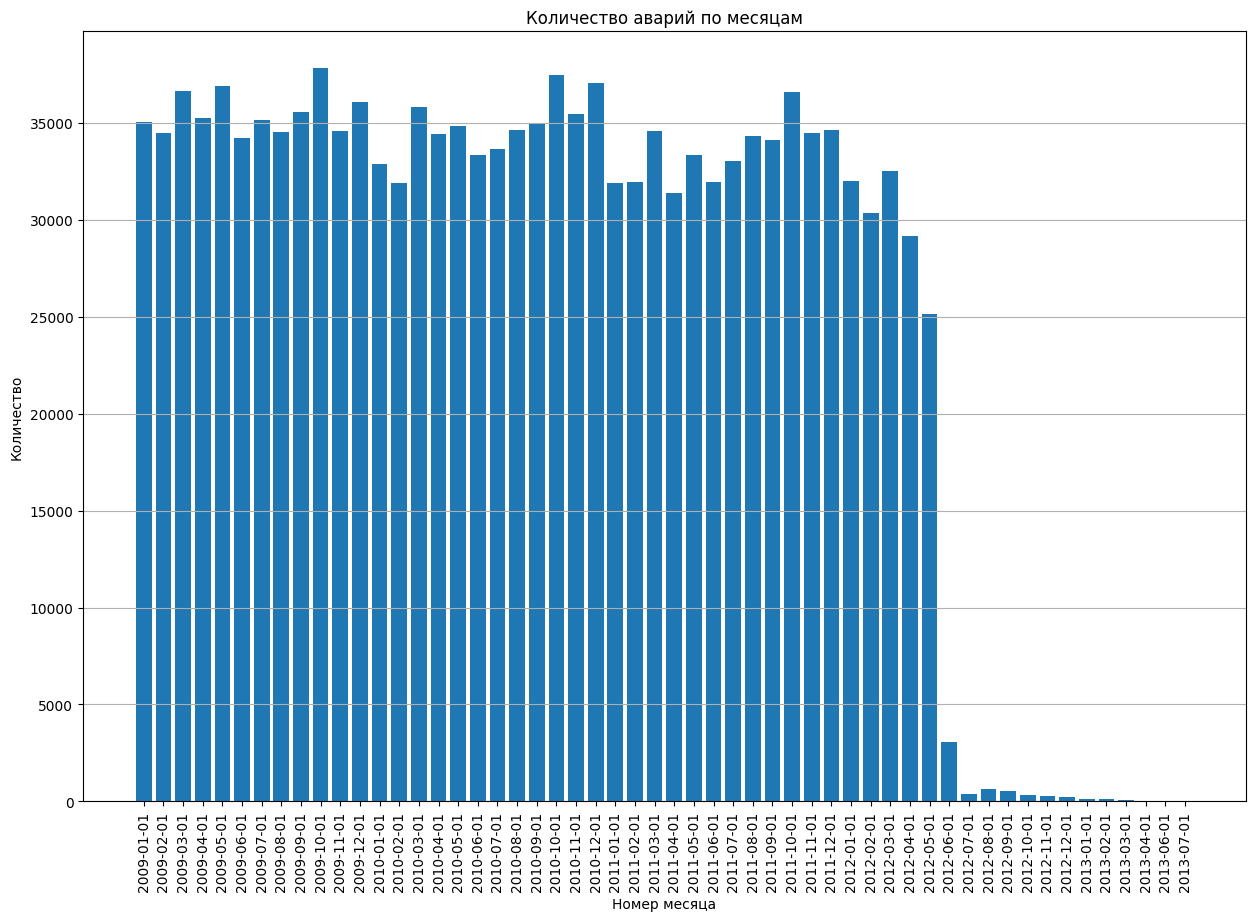

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(range(collisions_df.shape[0]), collisions_df['count'])
plt.title('Количество аварий по месяцам')
plt.xlabel('Номер месяца')
plt.ylabel('Количество')
plt.xticks(range(collisions_df.shape[0]),labels=collisions_df['month'].values, rotation=90)
plt.grid(True, axis='y')
plt.show();

* Какой-то общей зависимости от месяца нет.

* С июня 2012 года данных стало намного меньше, поэтому в дальнейшем буду убирать данные за этот период.

* Не буду учитывать месяц как признак дальше. Есть признаки, характеризующие погодные условия, они и покроют эту фичу.

## Постановка задач анализа признаков и решение

Задачи:

* Какие по типу кузова автомобили наиболее часто попадают в аварии по серьезности MIDDLE DAMAGE?
  
* Как серьезность аварии зависит от нетрезвого состояния водителя?

Решение:
Для задачи (Какие по типу кузова автомобили наиболее часто попадают в аварии по серьезности MIDDLE DAMAGE) необходимо соединить две таблицы с авариями и с автомобилями по уникальному ключу, затем сгруппировать автомобили по типу кузова, считая количество аварий

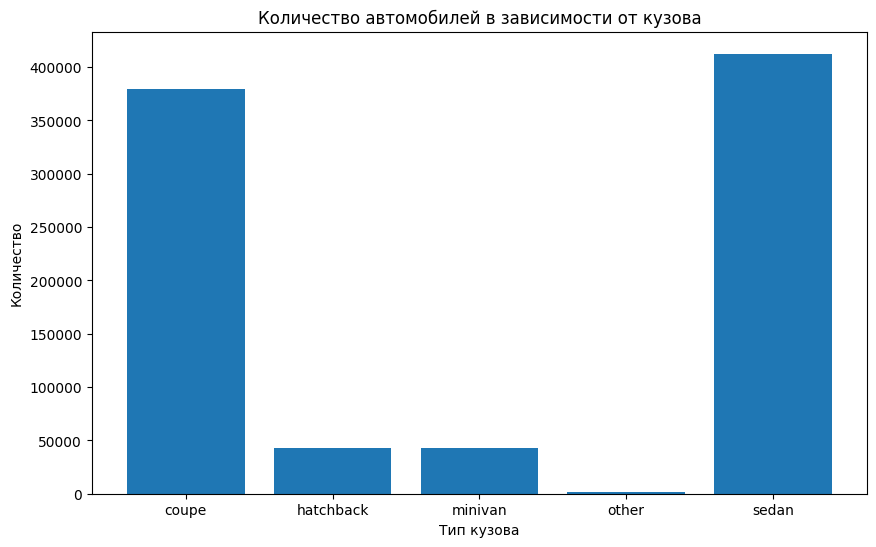

In [ ]:
query = '''
SELECT vehicle_type, COUNT(DISTINCT case_id)
FROM vehicles
GROUP BY vehicle_type
'''
df = pd.read_sql_query(query, con=con)
#display(df)
plt.figure(figsize=(10, 6))
plt.bar(df['vehicle_type'].unique(), df['count'], label=df['vehicle_type'].unique())
plt.xlabel('Тип кузова')
plt.ylabel('Количество')
plt.title('Количество автомобилей в зависимости от кузова')
plt.show();

Посмотрел, какое отношение авомобилей по типу кузова вообще в базе данных по всем происшествиям. Оказалось, что больше всего купе и седанов.

,vehicle_type,count
0,coupe,109081
1,sedan,43227
2,minivan,21689
3,hatchback,16428
4,other,416


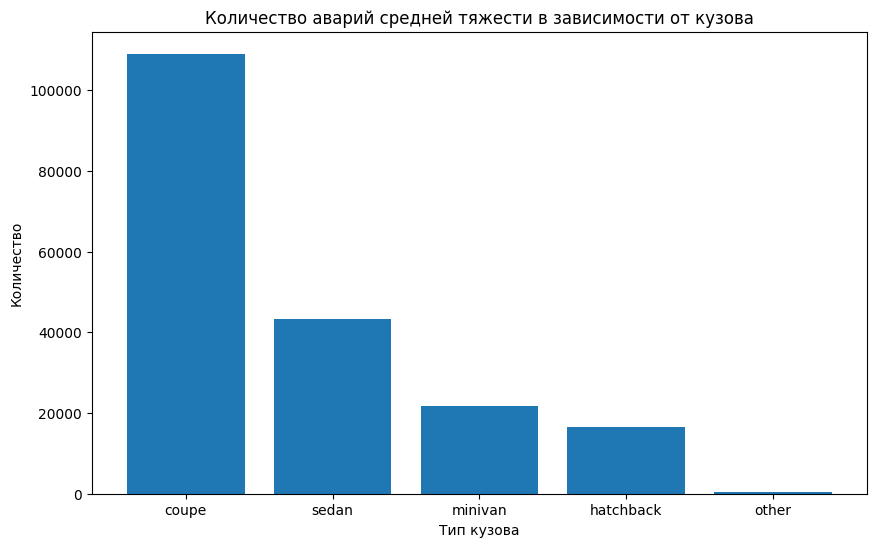

In [ ]:
query = '''
WITH cars AS (
SELECT case_id, vehicle_type, vehicle_transmission, vehicle_age
FROM vehicles)
SELECT cars.vehicle_type, COUNT(DISTINCT col.case_id)
FROM collisions col
INNER JOIN cars ON cars.case_id=col.case_id
WHERE col.collision_damage='middle damage'
AND DATE_TRUNC('month', collision_date)::date<'2012-06-01'
GROUP BY cars.vehicle_type
ORDER BY COUNT(DISTINCT col.case_id) DESC
LIMIT 6;
'''
df = pd.read_sql_query(query, con=con)
display(df)
plt.figure(figsize=(10, 6))
plt.bar(df['vehicle_type'], df['count'], label=df['vehicle_type'].unique())
plt.xlabel('Тип кузова')
plt.ylabel('Количество')
plt.title('Количество аварий средней тяжести в зависимости от кузова')
plt.show();

* Так как купе и седанов в датасете больше всего, то и аварий с ними больше, однако с купе аварий больше более чем в два раза, чем с седанами. А вот аварий с минивэнами со средней тяжестью больше, чем с хэтчбэками.

Задача: Как серьезность аварии зависит от нетрезвого состояния водителя.

Решение: связать две таблицы с авариями и с участниками, выбрать тех участников, которые были в нетрезвом состоянии. Сгрупировать по серьезности происшествия.

In [ ]:
query = '''
SELECT party_sobriety, COUNT(DISTINCT case_id)
FROM parties
GROUP BY party_sobriety
ORDER BY COUNT(DISTINCT case_id) DESC
'''
df = pd.read_sql_query(query, con=con)
display(df)


,party_sobriety,count
0,had not been drinking,1185724
1,impairment unknown,224079
2,not applicable,129640
3,"had been drinking, under influence",111559
4,None,57946
5,"had been drinking, impairment unknown",20975
6,"had been drinking, not under influence",15967


Посмотрел на количество участников по их состоянию трезвости. Больше всего трезвых участников.

,collision_damage,count
0,small damage,67226
1,middle damage,23050
2,scratch,17899
3,severe damage,6063
4,fatal,2854


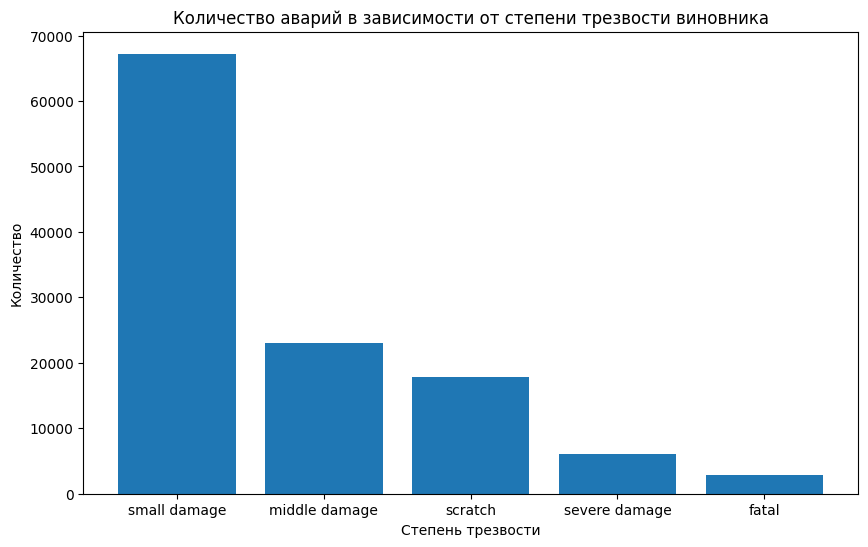

In [ ]:
query = '''
WITH p AS (
SELECT case_id, party_sobriety
FROM parties
WHERE at_fault=1 AND party_sobriety IN ('had been drinking, under influence',
'had been drinking, not under influence'))
SELECT col.collision_damage, COUNT(DISTINCT col.case_id)
FROM collisions col
INNER JOIN p ON p.case_id=col.case_id
WHERE DATE_TRUNC('month', collision_date)::date<'2012-06-01'
GROUP BY col.collision_damage
ORDER BY COUNT(DISTINCT col.case_id) DESC;
'''
df = pd.read_sql_query(query, con=con)
display(df)
plt.figure(figsize=(10, 6))
plt.bar(df['collision_damage'], df['count'])
plt.xlabel('Степень трезвости')
plt.ylabel('Количество')
plt.title('Количество аварий в зависимости от степени трезвости виновника')
plt.show();

* Оказалось, что больше всего аварий по вине нетрезвых водителей носят небольшую и среднюю серьезность.

## Подготовка набора данных на основе первичного предположения заказчика

* Загружаю признаки, которые показались наиболее важными для оценки вероятности ДТП. 

* Добавил комментарии к признакам, которые выбираю.

* Важно учитывать, что в БД есть признаки, которые известны только после ДТП. Для решения задачи они не подойдут.

In [ ]:
query = '''
WITH cp AS(
    WITH p AS (
        SELECT case_id id,
        party_number,
        party_drug_physical,
        party_sobriety,
        cellphone_in_use,
        at_fault
        FROM parties
        WHERE party_type='car')
    SELECT p.party_drug_physical,
    p.party_sobriety,
    p.cellphone_in_use,
    p.id,
    p.party_number,
    v.vehicle_age,
    p.at_fault
    FROM vehicles v
    INNER JOIN p ON p.id=v.case_id AND p.party_number=v.party_number)

SELECT col.distance, --при формировании маршрута, возможно, это важный фактор
col.intersection, --на перекрестке внимание водителя должно увеливаться
col.location_type, --в зависимости от типа дороги это может быть важным
col.weather_1, --погода часто становится помехой
col.pcf_violation_category,--категорию нарушения в некоторых случаях можно предсказать
col.road_surface,--покрытие дороги влияет на многие физические факторы(сцепление)
col.road_condition_1,--дорожное состояние является также важным физ фактором
col.lighting,--влияет на видимость, что очень важно
col.control_device,--этот фактор не описывает ДТП, мне не очень понятно, что это.
                    --необходимо уточнить у заказчика, но он лишним не будет
cp.party_drug_physical, --медикаменты и мало сна могут повлиять на реакцию водителя
cp.party_sobriety, --один из важнейших факторов, снижающий внимание водителя
cp.cellphone_in_use, --телефон за рулем может отвлесь
cp.id, --уникальный id для проверки дубликатов
cp.vehicle_age, --старым авто нужно больше внимание, а некоторые водить сложнее
        --Кроме того, когда старый автомобиль в последний раз был на ТО? 
        -- возможно это было бы важно знать
cp.at_fault --целевой признак

FROM collisions col
INNER JOIN cp ON cp.id=col.case_id
WHERE col.collision_damage!='scratch' AND EXTRACT(YEAR FROM
CAST(col.collision_date AS date))=2012
'''
df = pd.read_sql_query(query, con=con)
display(df.head())

,distance,intersection,location_type,weather_1,pcf_violation_category,road_surface,road_condition_1,lighting,control_device,party_drug_physical,party_sobriety,cellphone_in_use,id,vehicle_age,at_fault
0,0.0,1.0,None,clear,traffic signals and signs,dry,normal,daylight,functioning,None,had not been drinking,0.0,5461918,3.0,0
1,30.0,0.0,None,clear,wrong side of road,dry,normal,daylight,functioning,None,had not been drinking,0.0,5513536,10.0,0
2,30.0,0.0,ramp,cloudy,speeding,dry,normal,daylight,functioning,None,had not been drinking,NaN,5608843,2.0,0
3,197.0,0.0,None,clear,speeding,dry,normal,daylight,functioning,None,had not been drinking,0.0,5458050,0.0,0
4,218.0,0.0,None,raining,speeding,wet,normal,daylight,functioning,None,had not been drinking,0.0,5458124,NaN,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   distance                56248 non-null  float64
 1   intersection            56073 non-null  float64
 2   location_type           25932 non-null  object 
 3   weather_1               56080 non-null  object 
 4   pcf_violation_category  55482 non-null  object 
 5   road_surface            55900 non-null  object 
 6   road_condition_1        55999 non-null  object 
 7   lighting                56094 non-null  object 
 8   control_device          56033 non-null  object 
 9   party_drug_physical     2857 non-null   object 
 10  party_sobriety          55376 non-null  object 
 11  cellphone_in_use        51777 non-null  float64
 12  id                      56248 non-null  object 
 13  vehicle_age             54554 non-null  float64
 14  at_fault                56248 non-null

In [ ]:
print('Количество явных дубликатов:', df.duplicated().sum())
df = df.drop_duplicates()
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 288
Количество явных дубликатов: 0


Есть явные дупликаты, удалил их.

In [ ]:
df = df.drop(['id'], axis=1)

Теперь удалю столбец id, так как мы уже проверили явные дубликаты.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55960 entries, 0 to 56247
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   distance                55960 non-null  float64
 1   intersection            55786 non-null  float64
 2   location_type           25780 non-null  object 
 3   weather_1               55793 non-null  object 
 4   pcf_violation_category  55200 non-null  object 
 5   road_surface            55618 non-null  object 
 6   road_condition_1        55714 non-null  object 
 7   lighting                55807 non-null  object 
 8   control_device          55745 non-null  object 
 9   party_drug_physical     2854 non-null   object 
 10  party_sobriety          55091 non-null  object 
 11  cellphone_in_use        51511 non-null  float64
 12  vehicle_age             54279 non-null  float64
 13  at_fault                55960 non-null  int64  
dtypes: float64(4), int64(1), object(9)
memory u

Проверю категориальные признаки на неявные дубликаты.

In [ ]:
cat_feat = df.select_dtypes(include='object').columns
for c in cat_feat:
    print(c, df[c].unique())
    print()

location_type [None 'ramp' 'highway' 'intersection']

weather_1 ['clear' 'cloudy' 'raining' 'fog' None 'snowing' 'wind' 'other']

pcf_violation_category ['traffic signals and signs' 'wrong side of road' 'speeding'
 'other hazardous violation' 'automobile right of way'
 'unsafe starting or backing' None 'following too closely'
 'unsafe lane change' 'dui' 'unknown' 'improper turning'
 'pedestrian violation' 'improper passing'
 'other than driver (or pedestrian)' 'hazardous parking'
 'other improper driving' 'pedestrian right of way' 'other equipment'
 'impeding traffic' 'brakes' 'lights' 'fell asleep']

road_surface ['dry' 'wet' None 'snowy' 'slippery']

road_condition_1 ['normal' 'construction' 'holes' 'loose material' 'other' 'obstruction'
 None 'flooded' 'reduced width']

lighting ['daylight' 'dark with street lights' 'dark with no street lights'
 'dusk or dawn' 'dark with street lights not functioning' None]

control_device ['functioning' 'none' 'not functioning' None 'obscured']

pa

Неявных дубликатов не обнаружил.

In [ ]:
a = df.isna().sum()/df.shape[0]*100
a = a.rename('Процент пропусков, %')
a

,"Процент пропусков, %"
distance,0.000000
intersection,0.310936
location_type,53.931380
weather_1,0.298427
pcf_violation_category,1.358113
road_surface,0.611151
road_condition_1,0.439600
lighting,0.273410
control_device,0.384203
party_drug_physical,94.899929


В данных есть пропуски.

In [ ]:
df = df.drop(['location_type', 'party_drug_physical'], axis=1)

Удалю столбцы 'location_type', 'party_drug_physical', так как пропусков в них больше 50%, восстановить верно нет возможности.

In [ ]:
df = df.dropna(subset=['intersection', 'lighting'])

В столбцах 'intersection', 'lighting' пропусков меньше 1%, поэтому просто удалю строки с пропусками.

In [ ]:
fillna_col = ['weather_1', 'pcf_violation_category',
            'road_surface', 'road_condition_1', 'control_device', 'party_sobriety',
            'cellphone_in_use']
for c in fillna_col:
    df[c] = df[c].fillna(df[c].mode()[0])
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median())
df.isna().sum()/df.shape[0]*100

,0
distance,0.0
intersection,0.0
weather_1,0.0
pcf_violation_category,0.0
road_surface,0.0
road_condition_1,0.0
lighting,0.0
control_device,0.0
party_sobriety,0.0
cellphone_in_use,0.0


Оставшиеся столбцы с пропусками категориальные, в них менее 10% пропусков, поэтому заменю пропуски на наиболее часто встречающиеся значения.

In [ ]:
print(df['intersection'].unique())
df['cellphone_in_use'].unique()

[1. 0.]


array([0., 1.])

Видим, что intersection задан через 0 и 1, но это категориальный признак, как и cellphone_in_use

In [ ]:
cat_feat = list(df.select_dtypes(include='object').columns)
cat_feat.extend(['intersection', 'cellphone_in_use'])
num_feat = ['distance', 'vehicle_age']
print(len(cat_feat))
len(num_feat)

9


2

Разделил признаки на категориальные и числовые.

In [ ]:
x = df.drop('at_fault', axis=1) # Признаки
y = df.at_fault # целевой признак
print(x.shape, y.shape)

(55634, 11) (55634,)


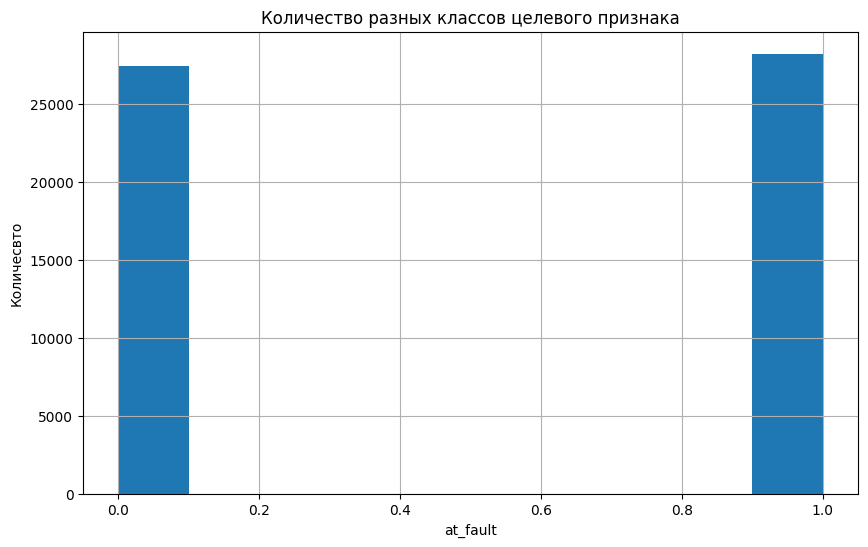

In [ ]:
plt.figure(figsize=(10, 6))
y.hist()
plt.xlabel('at_fault')
plt.ylabel('Количесвто')
plt.title('Количество разных классов целевого признака')
plt.show();

Целевой признак разделен почти равномерно, методы для балансировки классов не требуются. 

При разбиение на выборки, учту стратификацию.

In [ ]:
x[num_feat].describe()

,distance,vehicle_age
count,5.563400e+04,55634.000000
mean,8.631149e+02,4.833447
std,7.277705e+03,3.192438
min,0.000000e+00,0.000000
25%,8.000000e+00,3.000000
50%,1.360000e+02,4.000000
75%,5.500000e+02,7.000000
max,1.584000e+06,161.000000


Есть разброс в числовых признаках, требуется масштабирование.

In [ ]:
scaler = StandardScaler()
st = 12345 #random_state

Эмпирически StandardScaler() показал лучший результат.

In [ ]:
x[num_feat] = scaler.fit_transform(x[num_feat])
x[num_feat].describe()

,distance,vehicle_age
count,5.563400e+04,5.563400e+04
mean,-1.564538e-17,-1.274619e-16
std,1.000009e+00,1.000009e+00
min,-1.185982e-01,-1.514044e+00
25%,-1.174989e-01,-5.743145e-01
50%,-9.991081e-02,-2.610715e-01
75%,-4.302423e-02,6.786575e-01
max,2.175344e+02,4.891808e+01


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3, shuffle=True,
                                                    random_state=st, stratify=y)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38943, 11)
(16691, 11)
(38943,)
(16691,)


Разбил данные на тренировочную и тестовую выборки в отношении 7:3.

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=22)

In [ ]:
enc.fit(X_train[cat_feat])
train_enc = pd.DataFrame(enc.transform(X_train[cat_feat]),
             columns=cat_feat)
test_enc = pd.DataFrame(enc.transform(X_test[cat_feat]),
             columns=cat_feat)
X_train_enc = pd.concat([X_train[num_feat], train_enc], axis=1)
X_test_enc = pd.concat([X_test[num_feat], test_enc], axis=1)
print(X_train_enc.shape)
print(X_test_enc.shape)
X_train_enc.sample(3)

(38943, 11)
(16691, 11)


,distance,vehicle_age,weather_1,pcf_violation_category,road_surface,road_condition_1,lighting,control_device,party_sobriety,intersection,cellphone_in_use
38620,0.606912,-0.887558,1.0,8.0,3.0,4.0,0.0,1.0,3.0,0.0,0.0
35915,0.534361,-1.200801,0.0,8.0,0.0,4.0,0.0,1.0,3.0,0.0,0.0
5460,0.099055,-0.574315,0.0,2.0,0.0,4.0,1.0,1.0,2.0,0.0,0.0


In [ ]:
ohe.fit(X_train[cat_feat])
train_ohe = pd.DataFrame(ohe.transform(X_train[cat_feat]).toarray(),
             columns=ohe.get_feature_names_out())
test_ohe = pd.DataFrame(ohe.transform(X_test[cat_feat]).toarray(),
             columns=ohe.get_feature_names_out())
X_train_ohe = pd.concat([X_train[num_feat], train_ohe], axis=1)
X_test_ohe = pd.concat([X_test[num_feat], test_ohe], axis=1)

print(X_train_ohe.shape)
print(X_test_ohe.shape)
X_train_ohe.sample(3)

(38943, 53)
(16691, 53)


,distance,vehicle_age,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,pcf_violation_category_brakes,pcf_violation_category_dui,...,control_device_none,control_device_not functioning,control_device_obscured,"party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,intersection_1.0,cellphone_in_use_1.0
26961,-0.118598,0.678658,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26831,0.046290,1.305144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36754,-0.114476,-0.887558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


* Использовал ohe для кодирования категориальных признаков, так как потом буду использовать нейронку.

* OrdinalEncoder использую для деревянных и бустинговых моделей.

## Разработка моделей

В качестве метрики качества использую f1-меру.

### Логистическая регрессия

In [ ]:
lr = GridSearchCV(LogisticRegression(random_state=st, penalty='l2'), {'C': [2, 1, 0.7],
                                                                     'solver': ['newton-cg',
                                                                                'lbfgs'],
                                                                     'max_iter': [300, 350, 400]},
                 refit='f1',  cv=StratifiedKFold(5))
lr.fit(X_train_ohe, y_train)
print(lr.best_params_)
print('f1:', lr.best_score_)

{'C': 2, 'max_iter': 300, 'solver': 'newton-cg'}
f1: 0.6622243134158025


Подбирал гиперпараметры solver, C (для solver) и количество итераций. Лучшая метрика = 0.66

### Лес решений

In [ ]:
dt = GridSearchCV(RandomForestClassifier(random_state=st), {'max_depth': [12, 15, 20],
                                            'n_estimators': [55, 60, 65],
                                            'criterion': ['gini', 'entropy', 'log_loss']},
                 refit='f1',  cv=StratifiedKFold(5))
dt.fit(X_train_enc, y_train)
print(dt.best_params_)
print(dt.best_score_)

{'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 55}
0.6706983588658311


Для леса подбирал глубину, количество деревьев и функцию, которую минимизируем. Лучшая метрика 0.67.

### XGB

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Используется GPU")
else:
    device = torch.device("cpu")
    print("Используется CPU")

Используется GPU


In [ ]:
xgb = XGBClassifier(objective="binary:logistic", learning_rate=0.02,
                    silent=True, n_estimators=600)#, tree_method='gpu_hist'
params = {
        'depth': [10, 12, 14],
        'learning_rate': [0.001, 0.01, 0.05]
        }

CV_xgb = GridSearchCV(xgb, param_grid=params, refit='f1',
                      cv=StratifiedKFold(5), error_score='raise', n_jobs=1);
CV_xgb.fit(X_train_enc, y_train);
print(CV_xgb.best_params_)
print(CV_xgb.best_score_)

{'depth': 10, 'learning_rate': 0.01}
0.6754744667439885


XGBClassifier дал лучшую метрику f1: 0.675

### Многослойный перцептрон

In [ ]:
class net1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,
                 n_out_neurons):
        super(net1, self).__init__()

        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act1 = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act1(x)
        x = self.layer3(x)
        x = self.act1(x)
        return x

In [ ]:
model = net1(X_train_ohe.shape[1], 40, 12, 1) # количество нейронов
warnings.filterwarnings('ignore')

loss = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.5, alpha=0.9, eps=1e-05)

batch_size = 200
num_epochs = 201
num_batches = ceil(X_train_ohe.shape[0]/batch_size)
for epoch in range(num_epochs):
    order = np.random.permutation(X_train_ohe.shape[0])
    for batch_idx in range(num_batches):
        optimizer.zero_grad()
        st_ind = batch_idx*batch_size
        batch_indexes = order[st_ind:st_ind+batch_size]
        X_batch = torch.from_numpy(X_train_ohe.values[batch_indexes]).type(torch.FloatTensor)
        y_batch = torch.from_numpy(y_train.values[batch_indexes]).type(torch.FloatTensor)

        pred = model.forward(X_batch).flatten()
        loss_value = loss(pred, y_batch)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    if epoch%20 == 0 or epoch==num_epochs-1:
        model.eval()
        test_preds = model.forward(torch.from_numpy(X_test_ohe.values).type(torch.FloatTensor))
        test_preds = test_preds.detach().numpy().transpose()[0]
        for i in range(len(test_preds)):
            if test_preds[i]>=0.5:
                test_preds[i] = 1
            else:
                test_preds[i] = 0
        print(f'epoch: {epoch} f1_score:', f1_score(y_test, test_preds))

epoch: 0 f1_score: 0.6167365148032986
epoch: 20 f1_score: 0.5633911965282083
epoch: 40 f1_score: 0.6508816748707085
epoch: 60 f1_score: 0.5715800636267232
epoch: 80 f1_score: 0.5702101736216875
epoch: 100 f1_score: 0.4166969147005445
epoch: 120 f1_score: 0.5524792742061629
epoch: 140 f1_score: 0.26461843409316155
epoch: 160 f1_score: 0.572468162522741
epoch: 180 f1_score: 0.5670979101278419
epoch: 200 f1_score: 0.6730004770233742


Разработал модель персептрона с двумя скрытыми слоями и функцией активации сигмойдой. Использовал батчнормализацию для предотвращения переобучения. 
Проверял на тестовых данных после каждой 20-ой эпохи метрику, просто чтобы знать, так как не брал валидационную выборку.

* В качестве меры использовал f1-меру.

* XGBClassifier дал лучшую метрику f1: 0.675

* Для подбора параметров использовал кросс-валидацию на 5 фолдах. 

###  Лучшая модель

Использую XGBClassifier с подходящими параметрами.

In [ ]:
#получение предсказаний на лесе решений
xgb = CV_xgb.best_estimator_
test_preds = xgb.predict(X_test_enc)
f1 = f1_score(y_test, test_preds)
print('f1:', f1)

f1: 0.64501312335958


Метрика на тестовых данных 0.645.

In [ ]:
pd.DataFrame(confusion_matrix(y_test, test_preds), columns=['1', '0'], index=[1, 0])

,1,0
1,6366,1860
0,3550,4915


Матрица ошибок

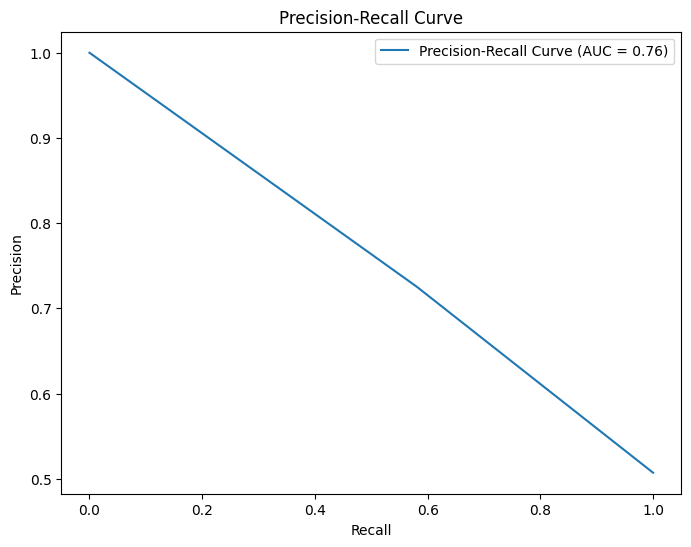

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, test_preds)
auc_score = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Площадь под графиком точности-полноты: 0.76 

* Метрика precision в данном случае обозначает, как много ответов, что ДТП произойдет не по вине водителя, нашла модель, пока искала ДТП, где водитель виновен.

* Метрика recall выявляет, какую долю составляют ДТП по вине водителя среди всех ДТП.

* На графике чем лучше классификатор разделяет два класса, тем больше площадь.

## Анализ важности признаков

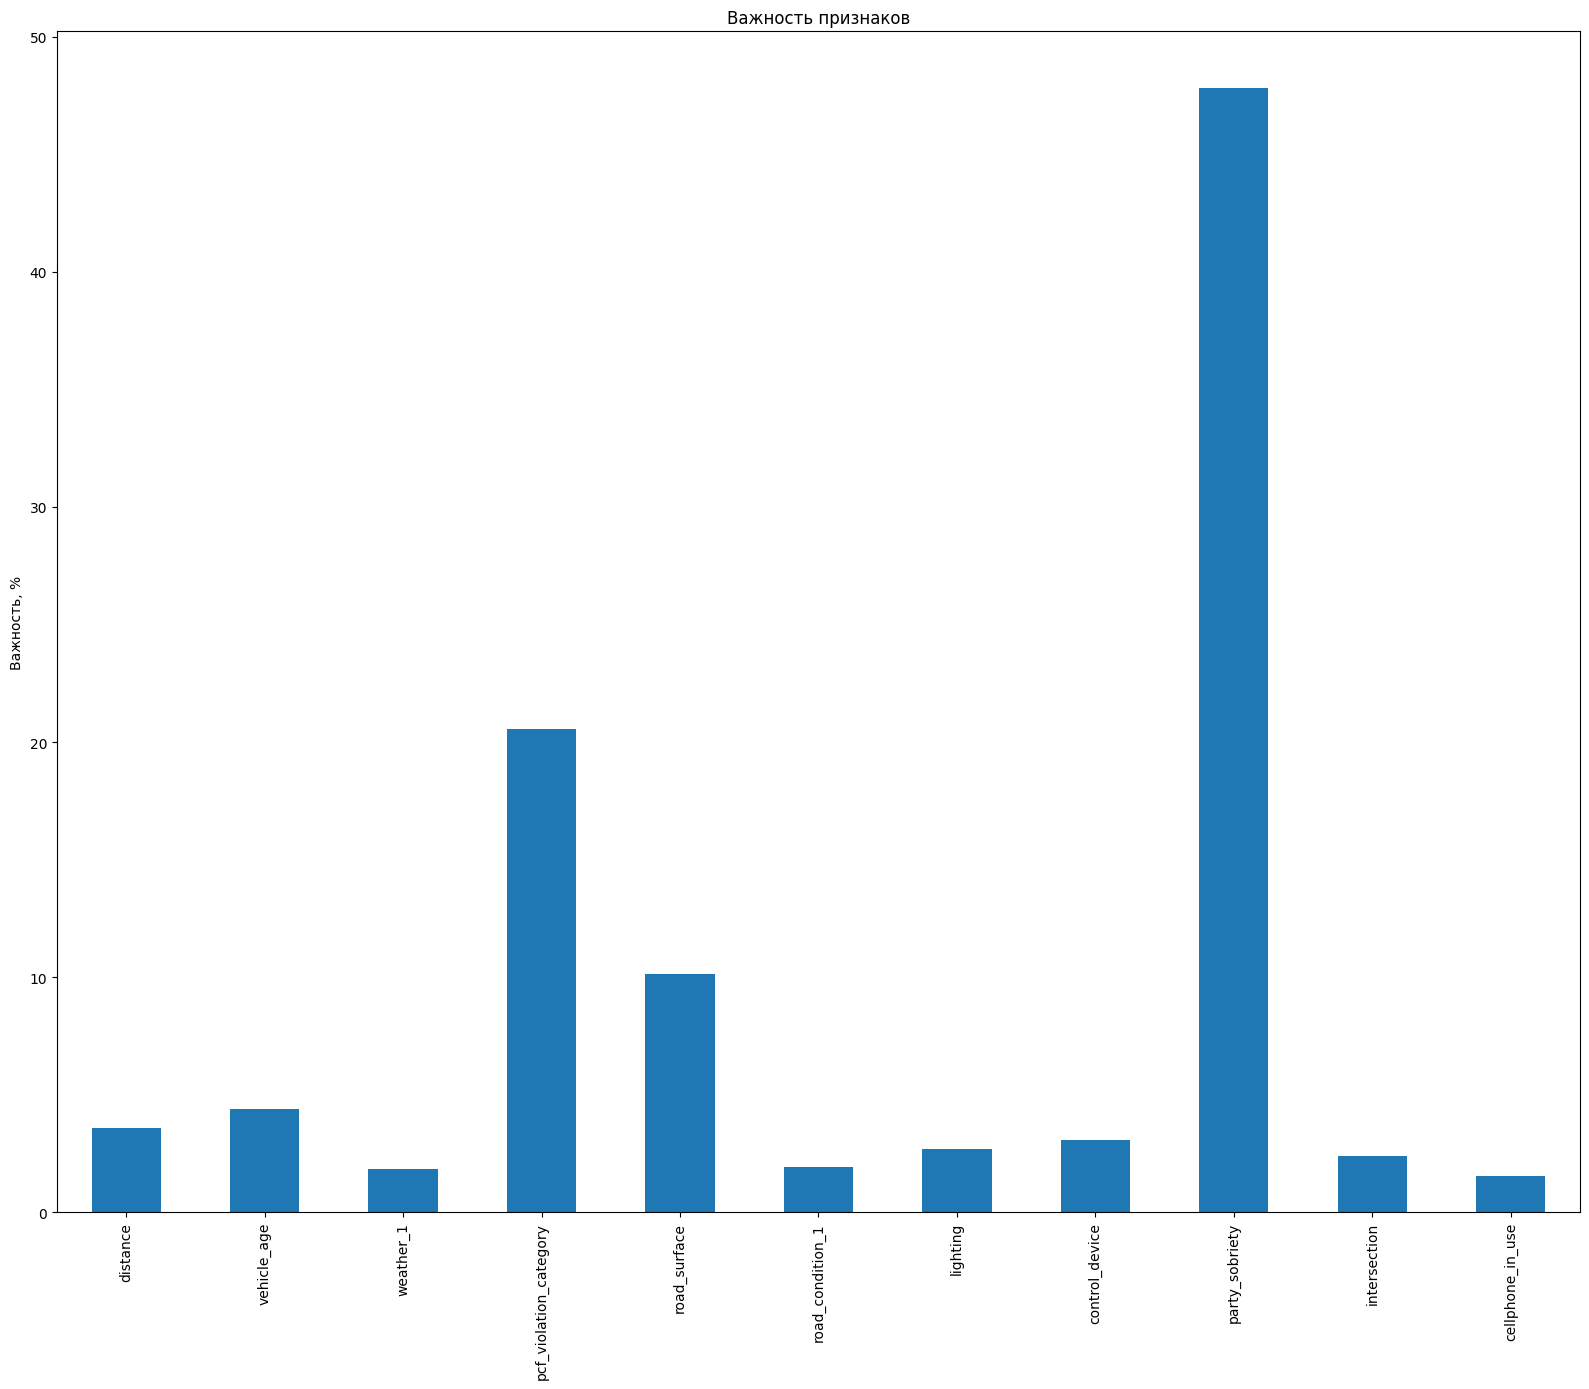

In [ ]:
importance = pd.Series(xgb.feature_importances_,
                         X_train_enc.columns)*100
importance = importance.loc[importance>1.5]
fig, ax = plt.subplots(figsize=(16,14))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Из важности признаков видим, что больше наиболее важными признаками были:

* Трезвость
* Категория нарушения
* Состояние дороги

Таким образом, одним из наиболее важных факторов при ДТП является трезвость водителя, как показала модель. А категорию нарушения можно рассматривать как уровень знания правил ПДД. 

Проанализируем, как трезвость влияет на ДТП.

In [ ]:
df1 = df[df['at_fault']==1].copy()
df2 = df[df['at_fault']==0].copy()

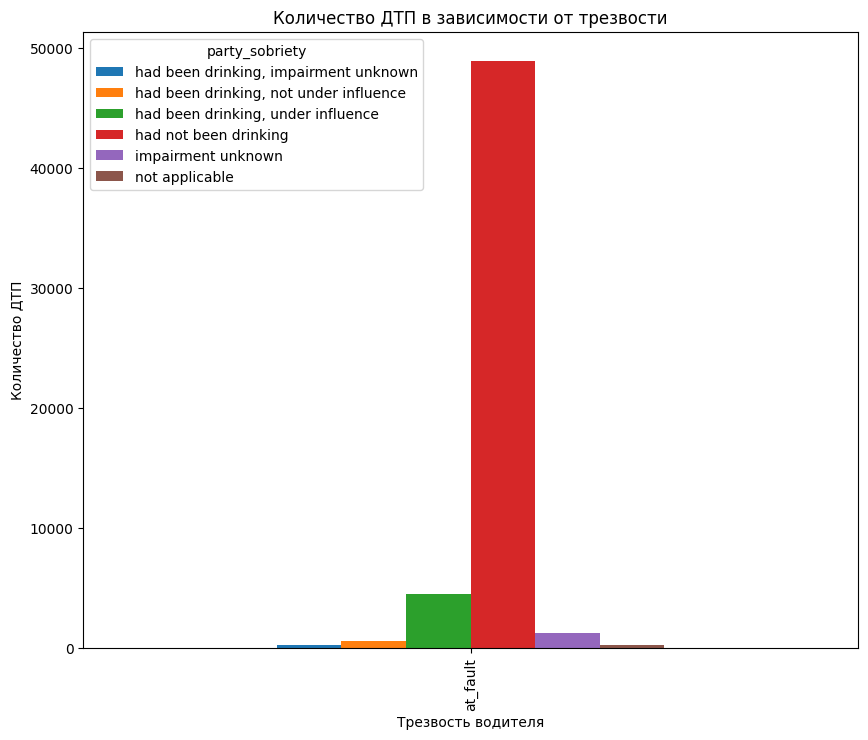

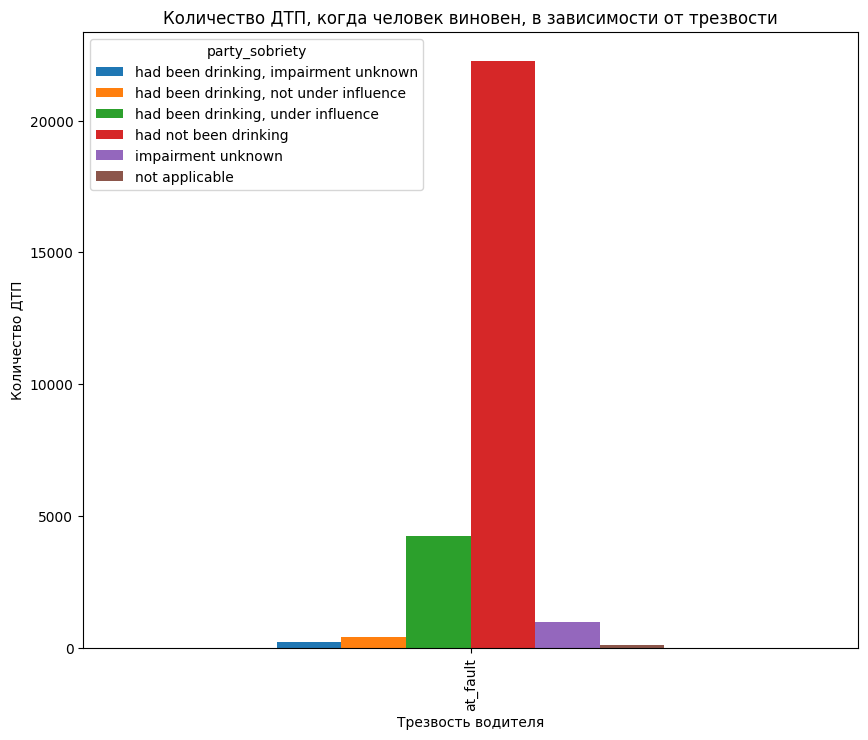

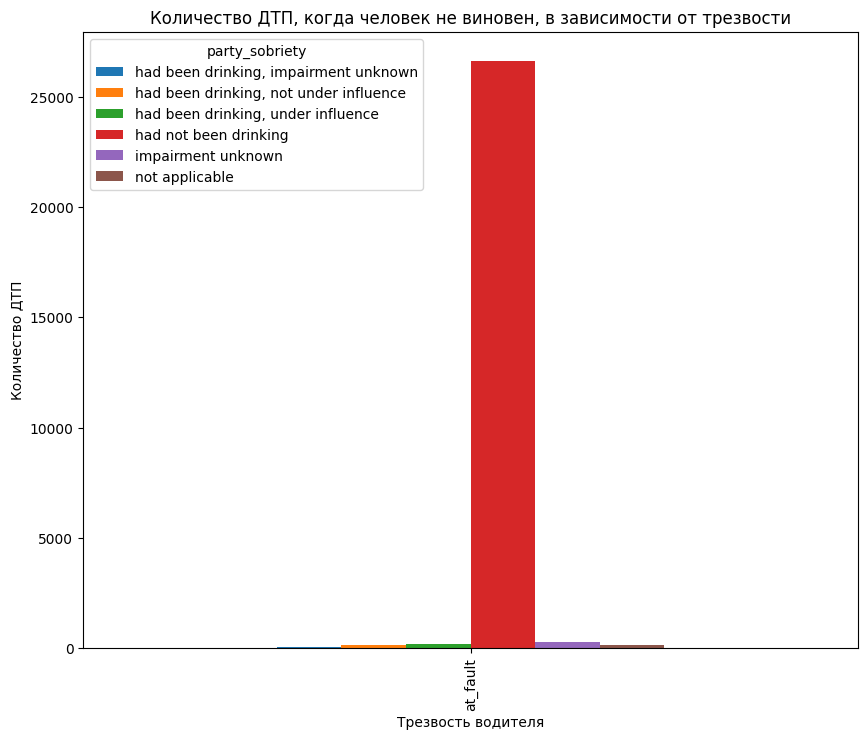

In [ ]:
pd.pivot_table(df, values='at_fault', columns='party_sobriety', aggfunc='count',
               margins_name=False).plot(kind='bar',figsize=(10, 8))
plt.xlabel('Трезвость водителя')
plt.ylabel('Количество ДТП')
plt.title('Количество ДТП в зависимости от трезвости')

pd.pivot_table(df1, values='at_fault', columns='party_sobriety', aggfunc='count',
               margins_name=False).plot(kind='bar',figsize=(10, 8))
plt.xlabel('Трезвость водителя')
plt.ylabel('Количество ДТП')
plt.title('Количество ДТП, когда человек виновен, в зависимости от трезвости')

pd.pivot_table(df2, values='at_fault', columns='party_sobriety', aggfunc='count',
               margins_name=False).plot(kind='bar',figsize=(10, 8))
plt.xlabel('Трезвость водителя')
plt.ylabel('Количество ДТП')
plt.title('Количество ДТП, когда человек не виновен, в зависимости от трезвости')

plt.show();


Из столбчатых диаграм видим, что большинство аварий произошло, когда человек не был пьян. Однако, если человек виновен в совершении ДТП, то на втором месте по трезвости стоит алгокольное опьянение. Если же не виновен, то большинство трезвых людей людей попадают в аварии.
Кроме того, ранее я рассматривал зависимость серьезности ДТП от того, был ли опьянен виновник, оказалось, что больше всего аварий по вине нетрезвых водителей носят небольшую и среднюю серьезность.
Я бы предложил оборудовать алкотеторами автомобили и направленными на водителя камерами.

А чтобы увеличить внимание водителей на пешеходов, припаркованные машины и велосипедистов, то встроить предупреждение, например, если водитель заехал во двор или едет по улице, где есть велосипедная дорожка, или пересекает дорожный переход, не оснащенные светофором.

## Выводы

***Знакомство с данными***
   
   - *Загрузка данных и проверка связей через ключ*
   
   - *Сделал первичный анализ данных*
    
   - *Создал несколько заданий для ознакомления с данными и выявлений зависимостей*
   
   - *Разделил на выборки*
    
***Подготовка данных***
   
   - *Удалил неинформативные столбцы*

   - *Нормализовал количественные признаки*
   
   - *Разделил на выборки*
    
   - *Использовал кодирование ohe и OrdinalEncoder категориальных признаков*

***Разработка модели ML***

   - *Нашел лучшие гиперпараметры, исходя из метрики f1. Использовал Gridsearch с кросс-валидацией*
   
   - *Рассмотрел логистическую регрессию, RandomForest и XGBClassifier.*

   - *Рассмотрел многослойный персептрон с двумя скрытыми слоями*
   
   - *Лучшей моделью стал XGBClassifier, лучшая метрика 0.645 на тестовой выборке*
   
***Анализ важности признаков***
   
   - *Наибольшее влиения на модель оказали следующие признаки: трезвость виновника, категория нарушения и состояние дороги.*

   - Большинство аварий произошло, когда человек не был пьян. Однако, если человек виновен в совершении ДТП, то на втором месте по уровню трезвости стоит алгокольное опьянение.
   

*Таким образом, создание модели оценки рисков ДТП - это вполне реализуемая задача. Я бы хотел запросить у заказчика дополнительные данные про стаж водителя, количество ДТП в которых он уже участвовал. Такие дополнительные данные смогли бы улучшить модель.*